<a href="https://colab.research.google.com/github/rendidwis315/AplikasiKotlin/blob/main/Uasdatascience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model 1 (Baseline) Selesai. Akurasi: 0.7824
Model 2 (Advanced) Selesai. Akurasi: 0.8301

Memulai Training Deep Learning (LSTM)...
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


415/415 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.5606 - loss: 1.7316 - val_accuracy: 0.7310 - val_loss: 1.0357
Epoch 2/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.7453 - loss: 0.9590 - val_accuracy: 0.7892 - val_loss: 0.7035
Epoch 3/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.7998 - loss: 0.6705 - val_accuracy: 0.8494 - val_loss: 0.5416
Epoch 4/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8580 - loss: 0.5026 - val_accuracy: 0.8602 - val_loss: 0.4717
Epoch 5/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8707 - loss: 0.4499 - val_accuracy: 0.8771 - val_loss: 0.4071
Epoch 6/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8821 - loss: 0.3938 - val_accuracy: 0.8877 - val_loss: 0.3638
Epoch 7/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8961 - loss: 0.3593 - val_accuracy: 0.8928 - val_loss: 0.3482
Epoch 8/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.8997 - loss: 0.3351 - val_accurac

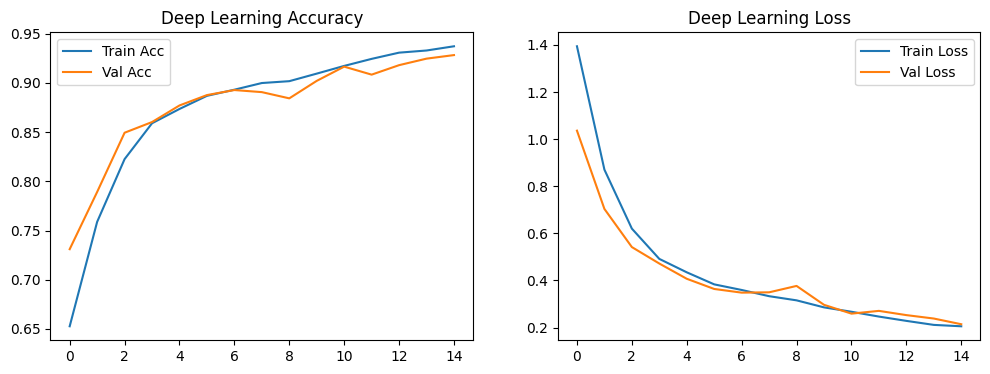


=== PERBANDINGAN MODEL ===
Model                     | Accuracy   | Training Time  
-------------------------------------------------------
1. Baseline (KNN)         | 0.7824     | 2.90           s
2. Advanced (R-Forest)    | 0.8301     | 60.54          s
3. Deep Learning (LSTM)   | 0.9282     | 372.96         s


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ==========================================
# 1. LOAD DATA & BASIC PREPROCESSING
# ==========================================
df = pd.read_csv('RecGym.csv')

# Pastikan label 'Workout' berupa angka (0, 1, 2, dst)
if df['Workout'].dtype == 'object':
    df['Workout'] = df['Workout'].astype('category').cat.codes

# Pilih fitur sensor
features = ['A_x', 'A_y', 'A_z', 'G_x', 'G_y', 'G_z', 'C_1']
X = df[features]
y = df['Workout']

# Scaling data agar rentang angka sama (penting untuk LSTM & KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================================
# 2. SLIDING WINDOW (Transformasi untuk Deep Learning)
# ==========================================
# LSTM butuh input 3D: [samples, time_steps, features]
def create_windows(X, y, window_size=50):
    X_list, y_list = [], []
    for i in range(0, len(X) - window_size, 10): # step 10 agar tidak terlalu berat
        X_list.append(X[i:i+window_size])
        y_list.append(y.iloc[i + window_size - 1])
    return np.array(X_list), np.array(y_list)

window_size = 50
X_win, y_win = create_windows(X_scaled, y, window_size)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_win, y_win, test_size=0.2, random_state=42)

# Data Flatten untuk Model Machine Learning Biasa (Baseline & Advanced)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# FIX: Ensure num_classes correctly reflects the max label value + 1
num_classes = int(np.max(y_win)) + 1

# ==========================================
# 3. MODEL 1: BASELINE (KNN)
# ==========================================
start_time = time.time()
model_baseline = KNeighborsClassifier(n_neighbors=5)
model_baseline.fit(X_train_flat, y_train)
acc_baseline = accuracy_score(y_test, model_baseline.predict(X_test_flat))
time_baseline = time.time() - start_time
print(f"Model 1 (Baseline) Selesai. Akurasi: {acc_baseline:.4f}")

# ==========================================
# 4. MODEL 2: ADVANCED (Random Forest)
# ==========================================
start_time = time.time()
model_advanced = RandomForestClassifier(n_estimators=100, random_state=42)
model_advanced.fit(X_train_flat, y_train)
acc_advanced = accuracy_score(y_test, model_advanced.predict(X_test_flat))
time_advanced = time.time() - start_time
print(f"Model 2 (Advanced) Selesai. Akurasi: {acc_advanced:.4f}")

# ==========================================
# 5. MODEL 3: DEEP LEARNING (LSTM) - WAJIB
# ==========================================
model_dl = Sequential([
    LSTM(64, input_shape=(window_size, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_dl.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\nMemulai Training Deep Learning (LSTM)...")
start_time = time.time()
history = model_dl.fit(
    X_train, y_train,
    epochs=15, # Minimal 10 sesuai syarat
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
time_dl = time.time() - start_time
acc_dl = model_dl.evaluate(X_test, y_test, verbose=0)[1]

# ==========================================
# 6. VISUALISASI & PERBANDINGAN
# ==========================================
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Deep Learning Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Deep Learning Loss')
plt.legend()
plt.show()

# Tabel Perbandingan Ringkas
print("\n=== PERBANDINGAN MODEL ===")
print(f"{'Model':<25} | {'Accuracy':<10} | {'Training Time':<15}")
print("-" * 55)
print(f"{'1. Baseline (KNN)':<25} | {acc_baseline:<10.4f} | {time_baseline:<15.2f}s")
print(f"{'2. Advanced (R-Forest)':<25} | {acc_advanced:<10.4f} | {time_advanced:<15.2f}s")
print(f"{'3. Deep Learning (LSTM)':<25} | {acc_dl:<10.4f} | {time_dl:<15.2f}s")